# Practica 4 - Base unificada (Listings)

Objetivo: construir una base unificada con `listings.csv.gz` y aplicar EDA, limpieza, ingenieria de variables y modelos supervisados.

- Target principal: `price` (regresion)
- Dataset local: `data/listings.csv.gz`

## Resumen Ejecutivo: Optimización de Precios de Alquiler en Airbnb CDMX

**Problemática a resolver**
El mercado de Airbnb en CDMX muestra una dispersión de precios extrema (aprox. 61 MXN a 900,000 MXN), con alta variabilidad y correlaciones débiles entre el precio y características básicas (capacidad, habitaciones). Esto sugiere ineficiencias en la fijación de precios: propiedades subvaloradas pierden ingresos y propiedades sobrevaloradas tienen baja ocupación.

**Justificación: por qué usar modelos supervisados**
Un modelo supervisado aprende patrones complejos entre características y precios históricos, permitiendo:
- Estimar un "precio justo" de mercado con base en datos.
- Detectar sub/sobrevaloración comparando precio actual vs. predicho.
- Escalar recomendaciones a miles de listados.
- Capturar relaciones no lineales e interacciones entre variables.
- Reentrenar periódicamente para adaptarse a cambios del mercado.

**Insights de negocio (EDA)**
- Segmentos de alto valor: *Hotel room* en *Room in hotel* y *Entire home/apt* en *Entire villa* o *Entire home* concentran precios altos.
- Zonas premium: Cuauhtémoc lidera en volumen y precio; Tlalpan, Cuajimalpa de Morelos y Álvaro Obregón destacan por precios promedio altos.
- Factores clave (correlaciones): capacidad, bedrooms, beds y bathrooms muestran relación positiva débil con el precio; *review_scores_rating* tiene relación muy baja.
- Outliers y asimetría: la distribución está sesgada a la derecha; ~8.54% de outliers por encima de ~2,660 MXN. La transformación logarítmica es clave para estabilizar la varianza.

**Métricas del modelo (criterios de selección)**
- **MAE**: error promedio absoluto.
- **RMSE**: penaliza errores grandes; sensible a outliers.
- **R²**: varianza explicada; valores altos son mejores.

**Resultados clave**
- Mejor MAE/RMSE en segmento estándar: Random Forest con MAE ~176.37 MXN y RMSE ~231.80 MXN.
- Mejor R² global: Random Forest con log-transform + winsorización (R² ~0.54).
- Segmento de lujo: desempeño pobre (R² negativos), lo que indica necesidad de features o enfoques adicionales.

**Caso de uso (usuario final)**
Un "Asesor Inteligente de Precios" integrado en la plataforma:
- Recomienda precio sugerido y rango de confianza.
- Alerta sub/sobrevaloración con impacto potencial en ingresos u ocupación.
- Explica factores más relevantes en el precio y sugiere mejoras.
- Permite monitoreo y ajuste dinámico por estacionalidad y competencia.

In [1]:
# === 1) Imports y configuracion ===
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, accuracy_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
    AdaBoostRegressor, VotingRegressor, RandomForestClassifier
)
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Optional: XGBoost (si esta instalado)
try:
    from xgboost import XGBRegressor, XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [2]:
# === 2) Carga de datos ===
DATA_DIR = Path("data")
if not DATA_DIR.exists():
    raise FileNotFoundError(f"No existe {DATA_DIR} en el directorio actual")

raw = pd.read_csv(DATA_DIR / "listings.csv.gz", compression="gzip", low_memory=False)
print("Shape:", raw.shape)
raw.head(3)

Shape: (27051, 79)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,35797,https://www.airbnb.com/rooms/35797,20250927041820,2025-09-27,city scrape,Villa Dante,"Dentro de Villa un estudio de arte con futon, ...","Santa Fe Shopping Mall, Interlomas Park and th...",https://a0.muscache.com/pictures/f395ab78-1185...,153786,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
1,44616,https://www.airbnb.com/rooms/44616,20250927041820,2025-09-28,city scrape,Condesa Haus,A new concept of hosting in mexico through a b...,NaN,https://a0.muscache.com/pictures/251410/ec75fe...,196253,...,4.78,4.98,4.47,NaN,f,9,4,2,0,0.38
2,56074,https://www.airbnb.com/rooms/56074,20250927041820,2025-09-28,city scrape,Great space in historical San Rafael,This great apartment is located in one of the ...,Very traditional neighborhood with all service...,https://a0.muscache.com/pictures/3005118/60dac...,265650,...,4.94,4.76,4.79,NaN,f,1,1,0,0,0.48


In [3]:
# Vista rapida
raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 27051 entries, 0 to 27050
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            27051 non-null  int64  
 1   listing_url                                   27051 non-null  str    
 2   scrape_id                                     27051 non-null  int64  
 3   last_scraped                                  27051 non-null  str    
 4   source                                        27051 non-null  str    
 5   name                                          27051 non-null  str    
 6   description                                   26309 non-null  str    
 7   neighborhood_overview                         13736 non-null  str    
 8   picture_url                                   27051 non-null  str    
 9   host_id                                       27051 non-null  int64  
 1

## 3) EDA rapido y diccionario de datos

In [4]:
# Resumen de nulos
missing = (raw.isna().mean() * 100).sort_values(ascending=False)
missing.head(20)

neighbourhood_group_cleansed    100.000000
calendar_updated                100.000000
license                         100.000000
neighborhood_overview            49.221840
neighbourhood                    49.221840
host_neighbourhood               45.336586
host_about                       40.031792
host_location                    21.540793
host_response_rate               14.620532
host_response_time               14.620532
beds                             12.960704
bathrooms                        12.923737
estimated_revenue_l365d          12.879376
price                            12.879376
review_scores_location           12.576245
review_scores_value              12.576245
review_scores_accuracy           12.576245
review_scores_cleanliness        12.576245
review_scores_checkin            12.576245
review_scores_communication      12.576245
dtype: float64

In [5]:
# Diccionario de datos (resumen)

def build_data_dictionary(df):
    rows = []
    n = len(df)
    for col in df.columns:
        s = df[col]
        dtype = str(s.dtype)
        n_missing = s.isna().sum()
        pct_missing = (n_missing / n) * 100
        n_unique = s.nunique(dropna=True)
        pct_unique = (n_unique / n) * 100
        sample = s.dropna().astype(str).head(3).tolist()
        mean_len = None
        if s.dtype == 'object':
            mean_len = s.dropna().astype(str).str.len().mean()
        rows.append({
            'column': col,
            'dtype': dtype,
            'n_missing': n_missing,
            'pct_missing': round(pct_missing, 2),
            'n_unique': n_unique,
            'pct_unique': round(pct_unique, 2),
            'mean_len_text': None if mean_len is None else round(mean_len, 1),
            'sample_values': sample
        })
    return pd.DataFrame(rows)

build_data_dictionary(raw).head(10)

,column,dtype,n_missing,pct_missing,n_unique,pct_unique,mean_len_text,sample_values
0,id,int64,0,0.00,27051,100.00,None,"[35797, 44616, 56074]"
1,listing_url,str,0,0.00,27051,100.00,None,"[https://www.airbnb.com/rooms/35797, https://w..."
2,scrape_id,int64,0,0.00,1,0.00,None,"[20250927041820, 20250927041820, 20250927041820]"
3,last_scraped,str,0,0.00,2,0.01,None,"[2025-09-27, 2025-09-28, 2025-09-28]"
4,source,str,0,0.00,2,0.01,None,"[city scrape, city scrape, city scrape]"
5,name,str,0,0.00,25638,94.78,None,"[Villa Dante, Condesa Haus, Great space in his..."
6,description,str,742,2.74,22124,81.79,None,"[Dentro de Villa un estudio de arte con futon,..."
7,neighborhood_overview,str,13315,49.22,10108,37.37,None,"[Santa Fe Shopping Mall, Interlomas Park and t..."
8,picture_url,str,0,0.00,26219,96.92,None,[https://a0.muscache.com/pictures/f395ab78-118...
9,host_id,int64,0,0.00,12046,44.53,None,"[153786, 196253, 265650]"


In [6]:
# Heuristicas para candidatos a eliminar (alta cardinalidad, muchos nulos, texto largo)

def detect_drop_candidates(df, missing_threshold=60, high_card_threshold=200, long_text_len=80):
    rows = []
    n = len(df)
    for col in df.columns:
        s = df[col]
        name = col.lower()
        n_unique = s.nunique(dropna=True)
        pct_unique = (n_unique / n) * 100 if n else 0
        pct_missing = s.isna().mean() * 100
        reasons = []

        if n_unique <= 1:
            reasons.append('constant')
        if pct_missing > missing_threshold:
            reasons.append(f'missing>{missing_threshold}%')
        if s.dtype == 'object' and n_unique > high_card_threshold:
            reasons.append(f'high_card>{high_card_threshold}')
        if s.dtype == 'object':
            mean_len = s.dropna().astype(str).str.len().mean()
            if mean_len and mean_len > long_text_len:
                reasons.append(f'long_text>{long_text_len}')
        if 'url' in name:
            reasons.append('url')

        if reasons:
            rows.append((col, reasons))
    return rows

candidates = detect_drop_candidates(raw)
print("Total candidatos:", len(candidates))
[c[0] for c in candidates][:15]

Total candidatos: 10


['listing_url',
 'scrape_id',
 'picture_url',
 'host_url',
 'host_thumbnail_url',
 'host_picture_url',
 'neighbourhood_group_cleansed',
 'calendar_updated',
 'has_availability',
 'license']

## 4) Limpieza de variables clave (price y rates)

In [7]:
# Copia de trabajo
_df = raw.copy()

# Limpieza de price -> numerico
if 'price' in _df.columns:
    _df['price_clean'] = (
        _df['price'].astype(str)
        .str.replace(r"[,\$]", "", regex=True)
        .str.strip()
    )
    _df['price_clean'] = pd.to_numeric(_df['price_clean'], errors='coerce')
else:
    raise ValueError("La columna 'price' no existe en listings.csv")

# Log-transform (para reducir sesgo)
_df['log_price'] = np.log1p(_df['price_clean'])

# Filas sin target
_df = _df.dropna(subset=['price_clean']).copy()

# Conversión de tasas (% -> [0,1])
rate_cols = ['host_response_rate', 'host_acceptance_rate']
for col in rate_cols:
    if col in _df.columns:
        _df[col] = pd.to_numeric(
            _df[col].astype(str).str.replace('%', '', regex=False),
            errors='coerce'
        ) / 100

_df[['price_clean', 'log_price']].describe().T

,count,mean,std,min,25%,50%,75%,max
price_clean,23567.0,1792.540841,13230.940558,61.000000,643.000000,1039.000000,1611.000000,900000.000000
log_price,23567.0,6.967369,0.766767,4.127134,6.467699,6.946976,7.385231,13.710151


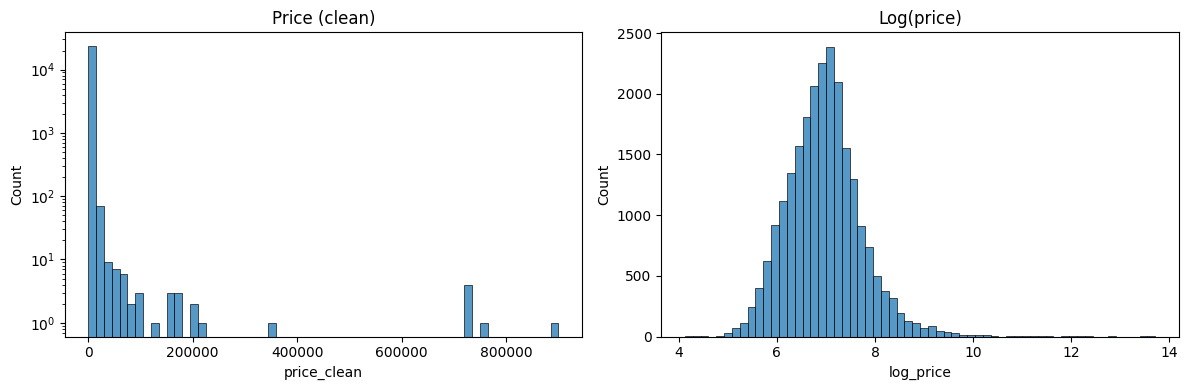

In [8]:
# Distribucion de precio (crudo vs log)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(_df['price_clean'].dropna(), bins=60, ax=axes[0])
axes[0].set_title('Price (clean)')
axes[0].set_yscale('log')

sns.histplot(_df['log_price'].dropna(), bins=60, ax=axes[1])
axes[1].set_title('Log(price)')

plt.tight_layout()
plt.show()

### Distribución y por qué usar log(price)

El precio tiene una cola larga a la derecha (muchos valores extremos). La transformación logarítmica:
- Reduce la asimetría y estabiliza la varianza.
- Hace visibles patrones en el rango medio.
- Ayuda a modelos lineales/regularizados a capturar mejor la estructura del dato.

In [9]:
# Resumen cuantílico del precio para evidenciar asimetría
_df['price_clean'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]).to_frame('price_clean')

,price_clean
count,23567.000000
mean,1792.540841
std,13230.940558
min,61.000000
50%,1039.000000
75%,1611.000000
90%,2628.000000
95%,3831.000000
99%,9918.580000
max,900000.000000


### EDA: variables continuas

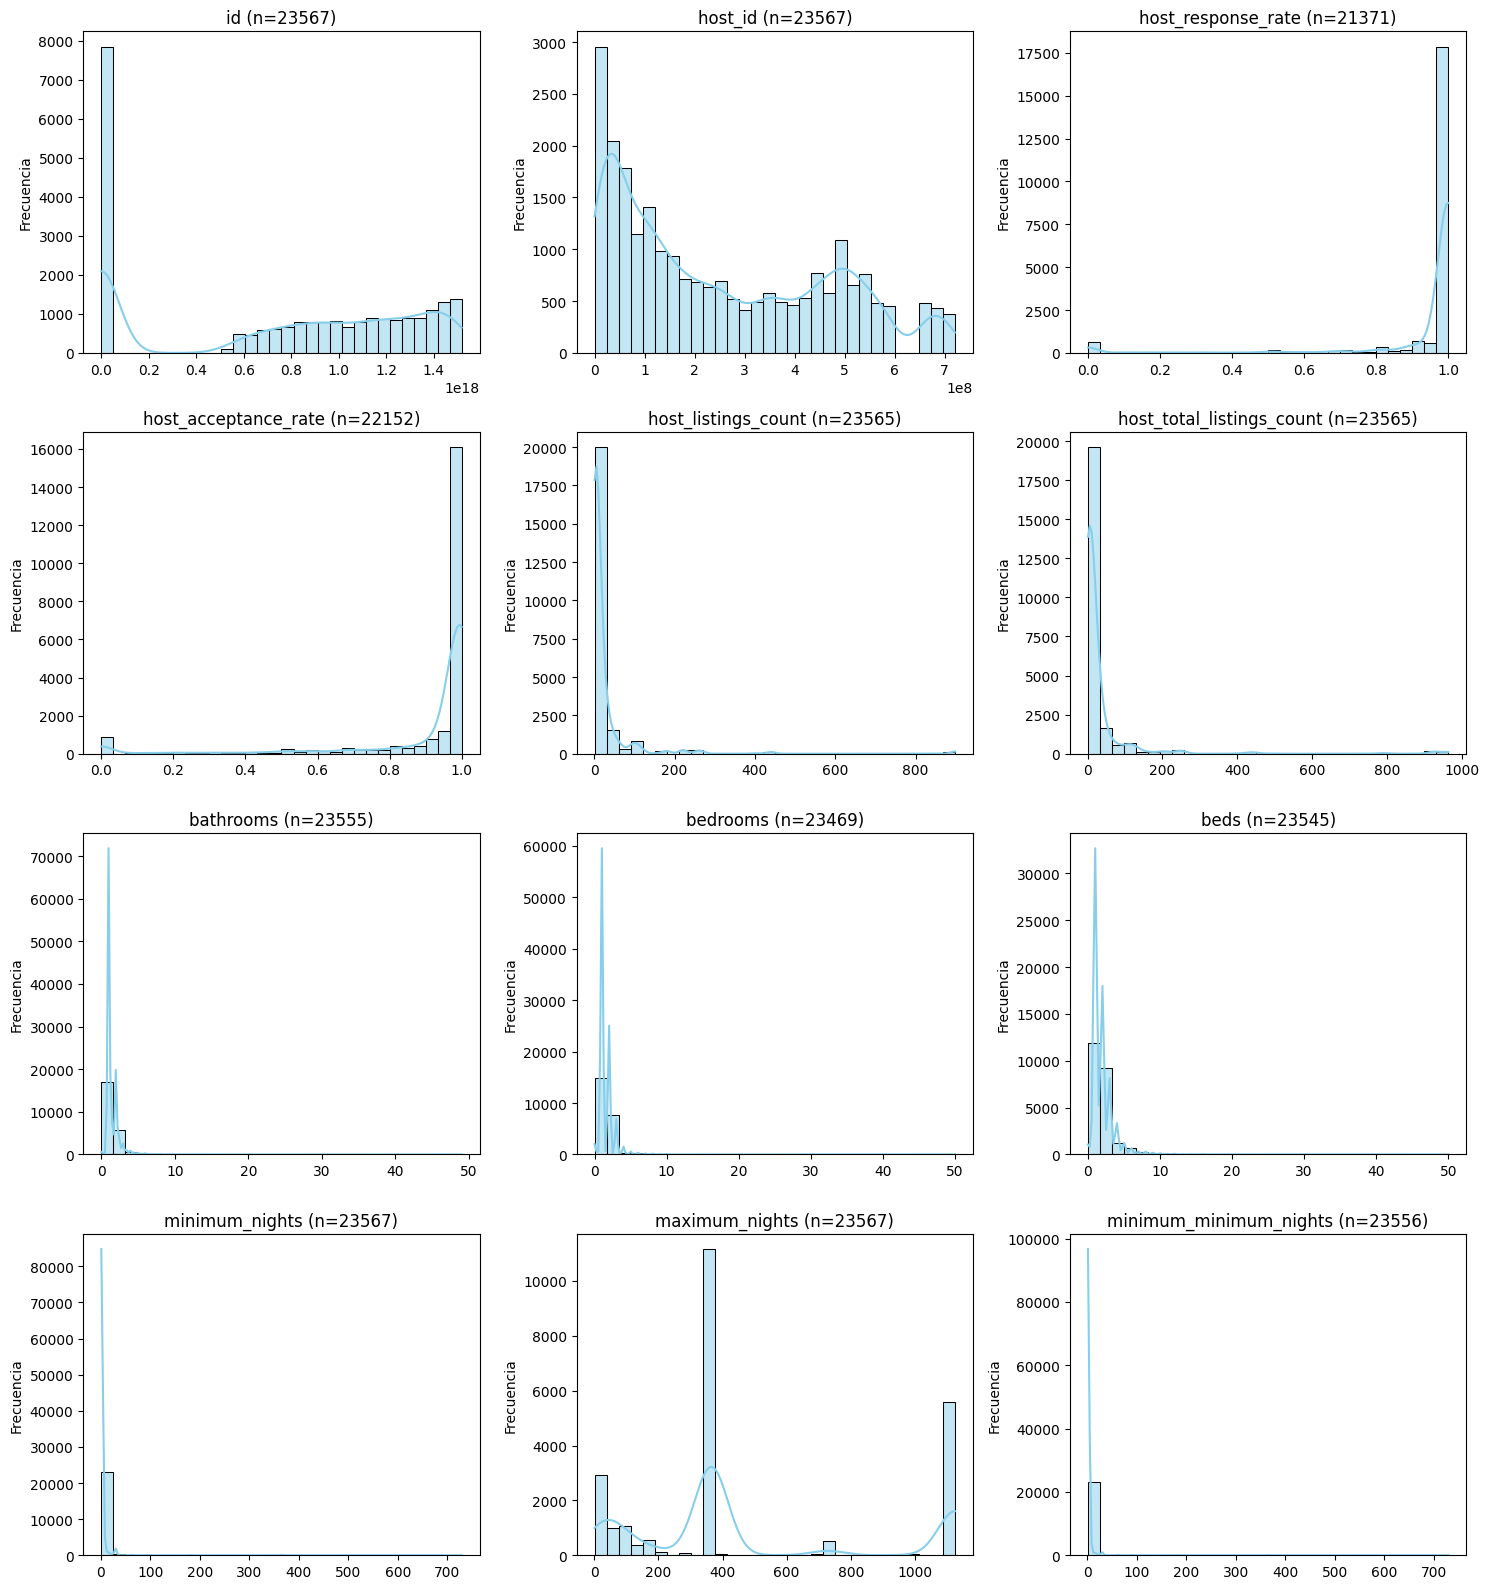

In [10]:
import math

exclude = ['latitude', 'longitude', 'log_price', 'price_clean']
cols_to_plot = [
    c for c in _df.select_dtypes(include=np.number).columns
    if c not in exclude and _df[c].nunique() > 20
]

cols_to_plot = cols_to_plot[:12]  # limite para evitar figuras enormes
n_cols = 3
n_rows = math.ceil(len(cols_to_plot) / n_cols) if cols_to_plot else 1

plt.figure(figsize=(15, n_rows * 4))

for i, col in enumerate(cols_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    data_clean = _df[col].dropna()
    sns.histplot(data_clean, kde=True, bins=30, color='skyblue')
    plt.title(f'{col} (n={len(data_clean)})')
    plt.xlabel('')
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

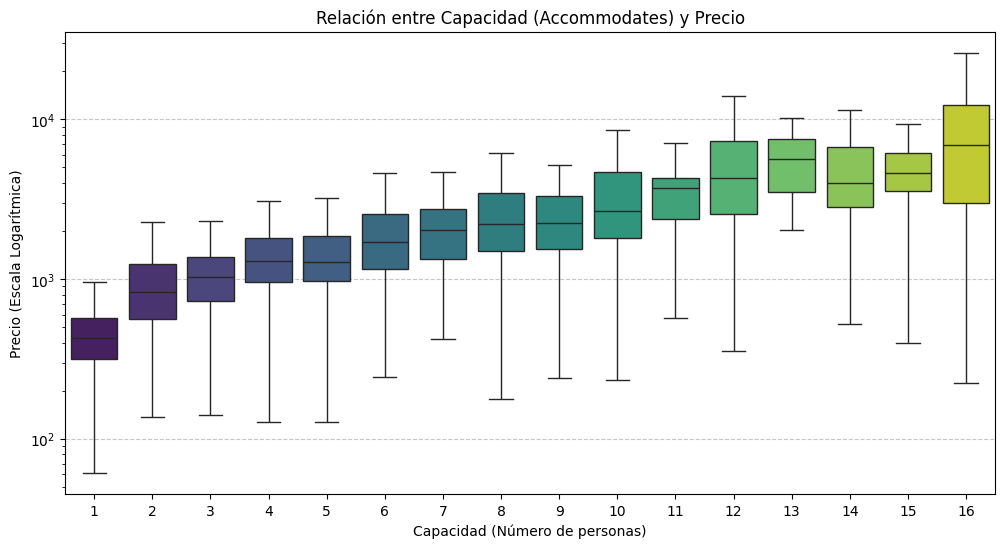

In [11]:
# Precio vs capacidad (accommodates)
if 'accommodates' in _df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='accommodates', y='price_clean', data=_df, palette='viridis', showfliers=False)
    plt.yscale('log')
    plt.title('Relación entre Capacidad (Accommodates) y Precio')
    plt.xlabel('Capacidad (Número de personas)')
    plt.ylabel('Precio (Escala Logarítmica)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

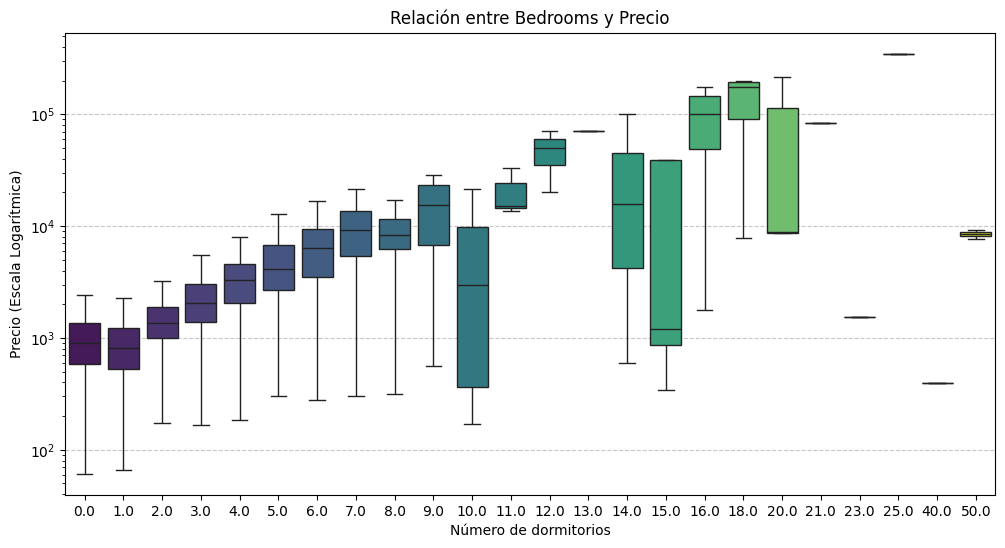

In [12]:
# Precio vs bedrooms
if 'bedrooms' in _df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='bedrooms', y='price_clean', data=_df, palette='viridis', showfliers=False)
    plt.yscale('log')
    plt.title('Relación entre Bedrooms y Precio')
    plt.xlabel('Número de dormitorios')
    plt.ylabel('Precio (Escala Logarítmica)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

### EDA: variables discretas (frecuencias)

In [13]:
# Frecuencias de variables categóricas clave
for col in ['room_type', 'neighbourhood_cleansed']:
    if col in _df.columns:
        print(f"\nFrecuencia: {col}")
        display(_df[col].value_counts(dropna=False).head(10))
        display((_df[col].value_counts(dropna=False, normalize=True).head(10) * 100).round(2))


Frecuencia: room_type


room_type
Entire home/apt    15896
Private room        7360
Shared room          254
Hotel room            57
Name: count, dtype: int64

room_type
Entire home/apt    67.45
Private room       31.23
Shared room         1.08
Hotel room          0.24
Name: proportion, dtype: float64


Frecuencia: neighbourhood_cleansed


neighbourhood_cleansed
Cuauhtémoc               11253
Miguel Hidalgo            3979
Benito Juárez             2528
Coyoacán                  1415
Venustiano Carranza        816
Álvaro Obregón             812
Tlalpan                    626
Gustavo A. Madero          459
Iztacalco                  441
Cuajimalpa de Morelos      349
Name: count, dtype: int64

neighbourhood_cleansed
Cuauhtémoc               47.75
Miguel Hidalgo           16.88
Benito Juárez            10.73
Coyoacán                  6.00
Venustiano Carranza       3.46
Álvaro Obregón            3.45
Tlalpan                   2.66
Gustavo A. Madero         1.95
Iztacalco                 1.87
Cuajimalpa de Morelos     1.48
Name: proportion, dtype: float64

### Top vecindarios por volumen y precio promedio

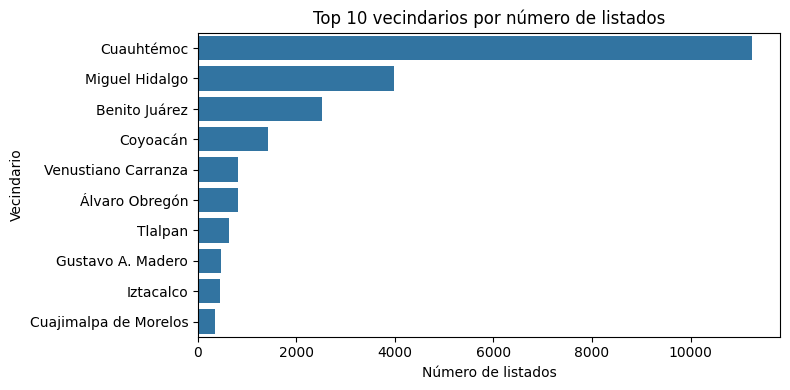

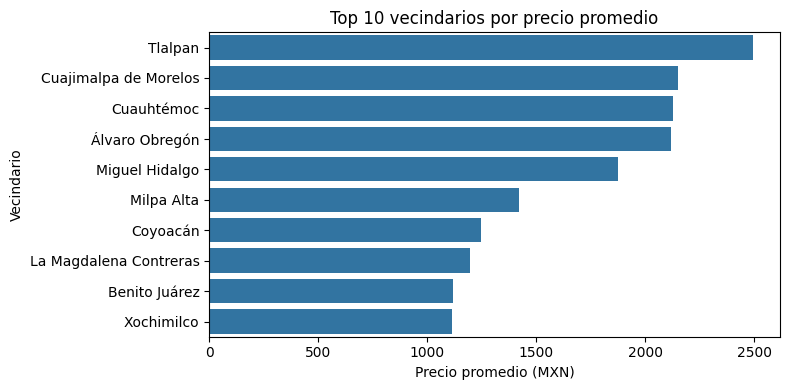

In [14]:
if 'neighbourhood_cleansed' in _df.columns:
    tmp = _df[['neighbourhood_cleansed', 'price_clean']].dropna()

    top_counts = tmp['neighbourhood_cleansed'].value_counts().head(10)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_counts.values, y=top_counts.index)
    plt.title('Top 10 vecindarios por número de listados')
    plt.xlabel('Número de listados')
    plt.ylabel('Vecindario')
    plt.tight_layout()
    plt.show()

    top_price = tmp.groupby('neighbourhood_cleansed')['price_clean'].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_price.values, y=top_price.index)
    plt.title('Top 10 vecindarios por precio promedio')
    plt.xlabel('Precio promedio (MXN)')
    plt.ylabel('Vecindario')
    plt.tight_layout()
    plt.show()

### Precio por property_type y vecindario (Top 10)

In [ ]:
# Top 10 property_type por volumen y comparación de precio
if 'property_type' in _df.columns:
    tmp = _df[['property_type', 'price_clean']].dropna()
    top_props = tmp['property_type'].value_counts().head(10).index
    tmp_top = tmp[tmp['property_type'].isin(top_props)]

    plt.figure(figsize=(10, 4))
    sns.countplot(y='property_type', data=tmp_top, order=top_props)
    plt.title('Top 10 property_type por número de listados')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.violinplot(x='property_type', y='price_clean', data=tmp_top, order=top_props, inner='quartile')
    plt.yscale('log')
    plt.title('Precio por property_type (Top 10)')
    plt.xlabel('property_type')
    plt.ylabel('Precio (escala log)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
# Precio por vecindario (Top 10 por volumen)
if 'neighbourhood_cleansed' in _df.columns:
    tmp = _df[['neighbourhood_cleansed', 'price_clean']].dropna()
    top_neigh = tmp['neighbourhood_cleansed'].value_counts().head(10).index
    tmp_top = tmp[tmp['neighbourhood_cleansed'].isin(top_neigh)]

    plt.figure(figsize=(12, 5))
    sns.boxplot(x='neighbourhood_cleansed', y='price_clean', data=tmp_top, order=top_neigh, showfliers=False)
    plt.yscale('log')
    plt.title('Precio por vecindario (Top 10)')
    plt.xlabel('Vecindario')
    plt.ylabel('Precio (escala log)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

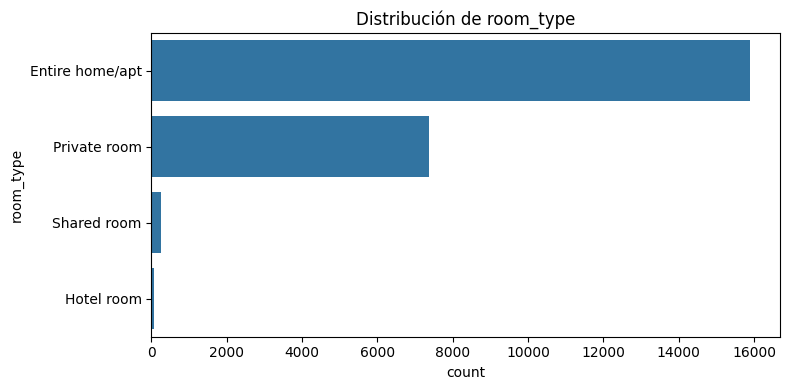

In [15]:
# Distribución por tipo de habitación
if 'room_type' in _df.columns:
    plt.figure(figsize=(8, 4))
    order = _df['room_type'].value_counts().index
    sns.countplot(y='room_type', data=_df, order=order)
    plt.title('Distribución de room_type')
    plt.tight_layout()
    plt.show()

In [16]:
# Histograma interactivo de room_type (Plotly)
import plotly.express as px

if 'room_type' in _df.columns:
    fig = px.histogram(_df.reset_index(), x='room_type', nbins=40, title='Histogram of room_type')
    fig.update_layout(xaxis_title='room_type', yaxis_title='Count')
    fig.show()

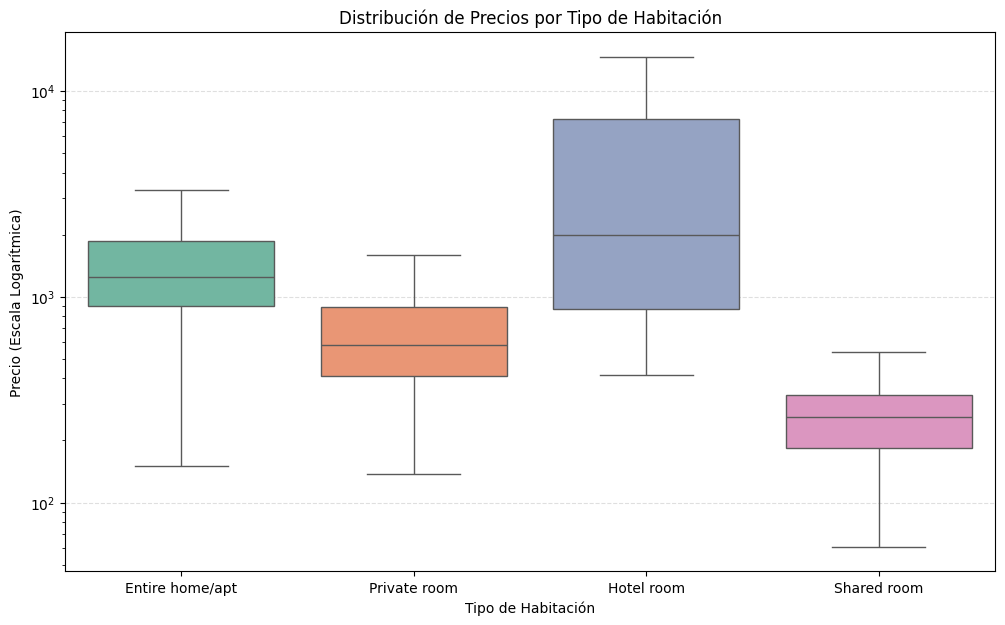

In [17]:
# Precio por tipo de habitación
if 'room_type' in _df.columns:
    plt.figure(figsize=(12, 7))
    order = ['Entire home/apt', 'Private room', 'Hotel room', 'Shared room']
    sns.boxplot(x='room_type', y='price_clean', data=_df, palette='Set2', order=order, showfliers=False)
    plt.yscale('log')
    plt.title('Distribución de Precios por Tipo de Habitación')
    plt.xlabel('Tipo de Habitación')
    plt.ylabel('Precio (Escala Logarítmica)')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.show()

### EDA: ubicación, demanda y anfitriones

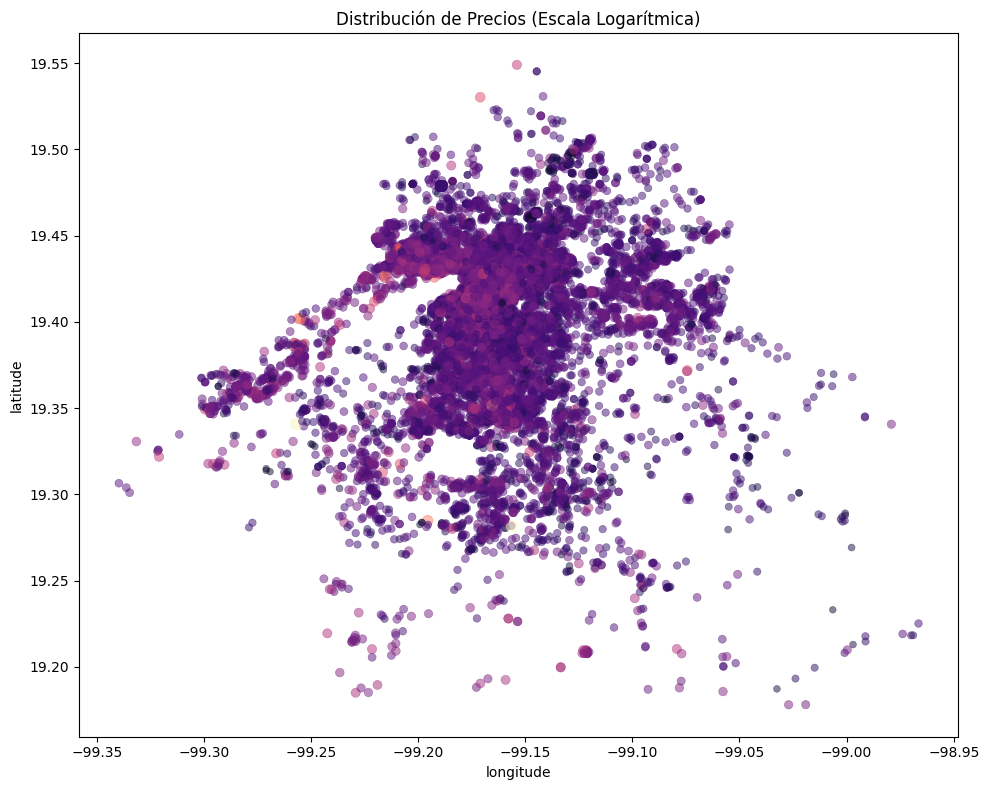

In [18]:
# Distribución geográfica de precios (dataset completo)
if {'latitude', 'longitude'}.issubset(_df.columns):
    plot_df = _df[['longitude', 'latitude', 'price_clean']].dropna()
    plot_df['price_log'] = np.log1p(plot_df['price_clean'])

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=plot_df,
        x='longitude',
        y='latitude',
        hue='price_log',
        size='price_log',
        palette='magma',
        alpha=0.5,
        edgecolor=None,
        legend=False
    )
    plt.title('Distribución de Precios (Escala Logarítmica)')
    plt.tight_layout()
    plt.show()

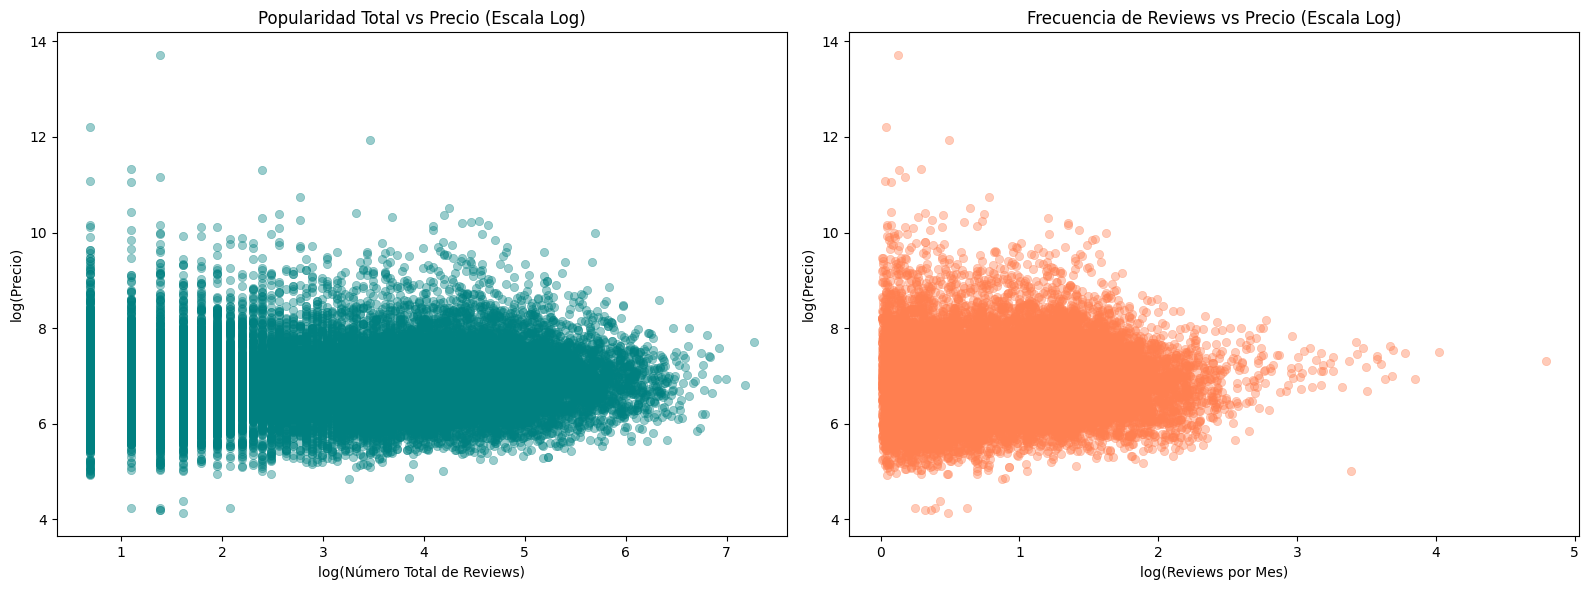

In [19]:
# Popularidad/actividad vs precio (escala log)
if {'number_of_reviews', 'reviews_per_month'}.issubset(_df.columns):
    plot_df = _df[['number_of_reviews', 'reviews_per_month', 'price_clean']].dropna()

    plot_df['log_number_of_reviews'] = np.log1p(plot_df['number_of_reviews'])
    plot_df['log_reviews_per_month'] = np.log1p(plot_df['reviews_per_month'])
    plot_df['log_price'] = np.log1p(plot_df['price_clean'])

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.scatterplot(
        data=plot_df, x='log_number_of_reviews', y='log_price',
        ax=axes[0], alpha=0.4, color='teal', edgecolor=None
    )
    axes[0].set_title('Popularidad Total vs Precio (Escala Log)')
    axes[0].set_xlabel('log(Número Total de Reviews)')
    axes[0].set_ylabel('log(Precio)')

    sns.scatterplot(
        data=plot_df, x='log_reviews_per_month', y='log_price',
        ax=axes[1], alpha=0.4, color='coral', edgecolor=None
    )
    axes[1].set_title('Frecuencia de Reviews vs Precio (Escala Log)')
    axes[1].set_xlabel('log(Reviews por Mes)')
    axes[1].set_ylabel('log(Precio)')

    plt.tight_layout()
    plt.show()

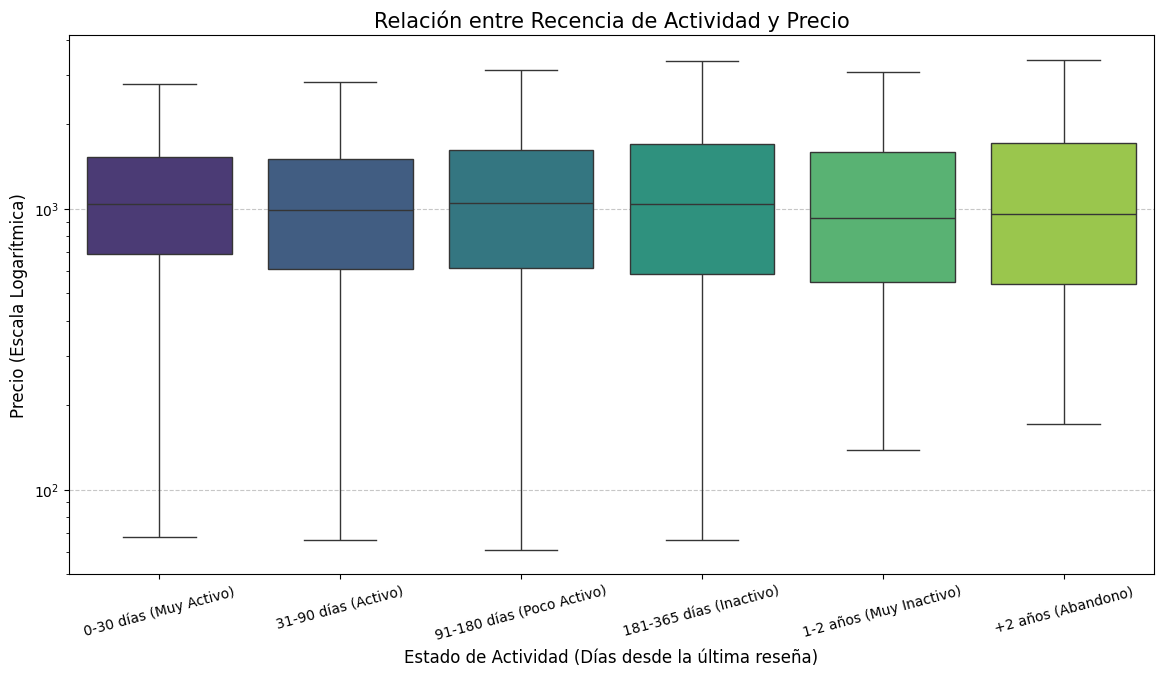

In [20]:
# Recencia de actividad vs precio
if {'last_review', 'last_scraped'}.issubset(_df.columns):
    tmp = _df[['last_review', 'last_scraped', 'price_clean']].copy()
    tmp['last_review'] = pd.to_datetime(tmp['last_review'], errors='coerce')
    tmp['last_scraped'] = pd.to_datetime(tmp['last_scraped'], errors='coerce')
    tmp['days_since_last_review'] = (tmp['last_scraped'] - tmp['last_review']).dt.days

    bins = [-1, 30, 90, 180, 365, 730, np.inf]
    labels = [
        '0-30 días (Muy Activo)',
        '31-90 días (Activo)',
        '91-180 días (Poco Activo)',
        '181-365 días (Inactivo)',
        '1-2 años (Muy Inactivo)',
        '+2 años (Abandono)'
    ]
    tmp['recency_group'] = pd.cut(tmp['days_since_last_review'], bins=bins, labels=labels)

    plt.figure(figsize=(14, 7))
    sns.boxplot(
        data=tmp,
        x='recency_group',
        y='price_clean',
        palette='viridis',
        showfliers=False
    )
    plt.title('Relación entre Recencia de Actividad y Precio', fontsize=15)
    plt.xlabel('Estado de Actividad (Días desde la última reseña)', fontsize=12)
    plt.ylabel('Precio (Escala Logarítmica)', fontsize=12)
    plt.yscale('log')
    plt.xticks(rotation=15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

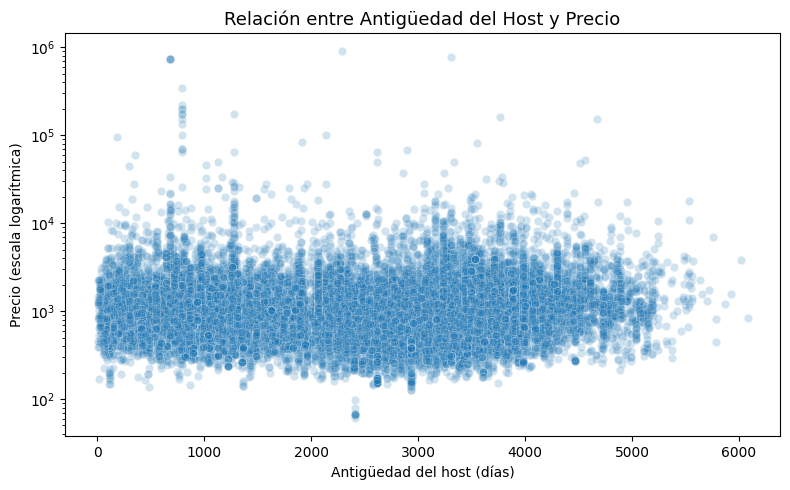

In [21]:
# Antigüedad del host vs precio
if {'host_since', 'last_scraped'}.issubset(_df.columns):
    tmp = _df[['host_since', 'last_scraped', 'price_clean']].copy()
    tmp['host_since'] = pd.to_datetime(tmp['host_since'], errors='coerce')
    tmp['last_scraped'] = pd.to_datetime(tmp['last_scraped'], errors='coerce')
    tmp['host_tenure_days'] = (tmp['last_scraped'] - tmp['host_since']).dt.days

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=tmp['host_tenure_days'], y=tmp['price_clean'], alpha=0.2)
    plt.yscale('log')
    plt.title('Relación entre Antigüedad del Host y Precio', fontsize=13)
    plt.xlabel('Antigüedad del host (días)')
    plt.ylabel('Precio (escala logarítmica)')
    plt.tight_layout()
    plt.show()

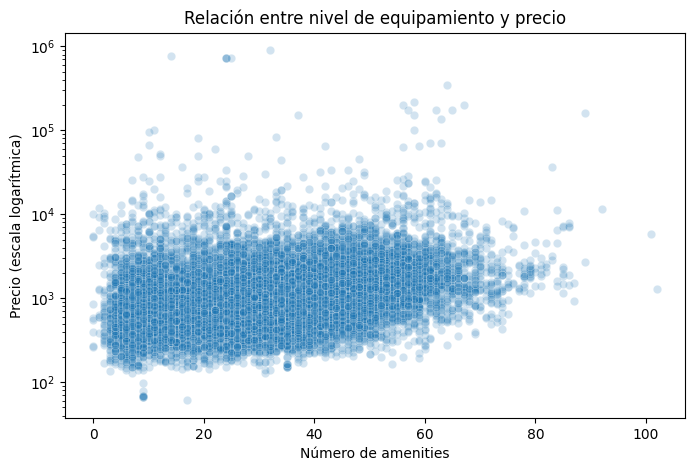

In [22]:
# Amenities vs precio
if 'amenities' in _df.columns:
    def _parse_listlike(val):
        if pd.isna(val):
            return []
        if isinstance(val, list):
            return val
        if isinstance(val, str):
            try:
                parsed = ast.literal_eval(val)
                if isinstance(parsed, list):
                    return parsed
            except Exception:
                pass
            cleaned = (
                val.replace('{', '').replace('}', '')
                   .replace('[', '').replace(']', '')
                   .replace('"', '')
            )
            return [v.strip() for v in cleaned.split(',') if v.strip()]
        return []

    _df['amenities_list'] = _df['amenities'].apply(_parse_listlike)
    _df['amenities_count'] = _df['amenities_list'].apply(len)

    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        x=_df['amenities_count'],
        y=_df['price_clean'],
        alpha=0.2
    )
    plt.yscale('log')
    plt.title('Relación entre nivel de equipamiento y precio')
    plt.xlabel('Número de amenities')
    plt.ylabel('Precio (escala logarítmica)')
    plt.show()

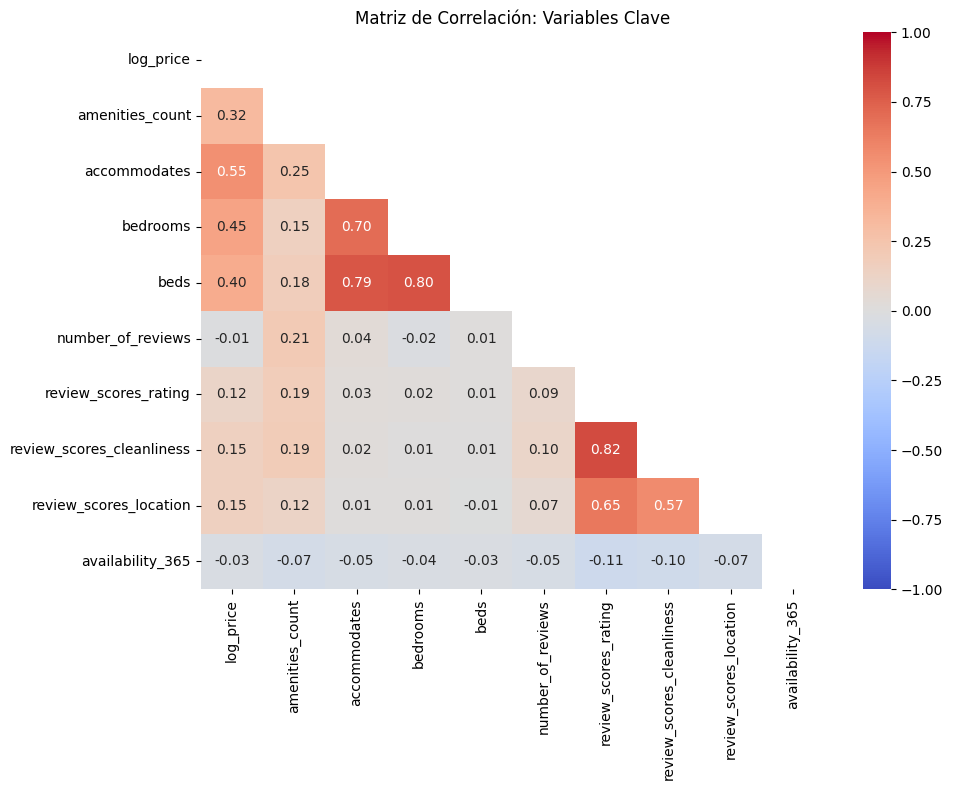

In [23]:
# Correlación de variables clave
cols_to_correlate = [
    'log_price', 'amenities_count', 'accommodates', 'bedrooms', 'beds',
    'number_of_reviews', 'review_scores_rating', 'review_scores_cleanliness',
    'review_scores_location', 'availability_365'
]
cols_final = [c for c in cols_to_correlate if c in _df.columns]
if len(cols_final) >= 2:
    corr_matrix = _df[cols_final].corr()
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, vmin=-1, vmax=1, center=0)
    plt.title('Matriz de Correlación: Variables Clave')
    plt.tight_layout()
    plt.show()

## 5) Ingenieria de variables (integrando Jimena + David)

In [24]:
# Trabajamos sobre df_model para features
_df_model = _df.copy()

# Precio por huesped
if 'accommodates' in _df_model.columns:
    _df_model['price_per_guest'] = np.where(
        _df_model['accommodates'] > 0,
        _df_model['price_clean'] / _df_model['accommodates'],
        np.nan
    )

# Huespedes por recamara
if 'bedrooms' in _df_model.columns and 'accommodates' in _df_model.columns:
    _df_model['guests_per_bedroom'] = np.where(
        _df_model['bedrooms'] > 0,
        _df_model['accommodates'] / _df_model['bedrooms'],
        np.nan
    )

In [ ]:
# Extra features: bathrooms_count y ratios
# bathrooms_text -> bathrooms_count
if 'bathrooms_text' in _df_model.columns:
    _df_model['bathrooms_count'] = (
        _df_model['bathrooms_text'].astype(str)
        .str.extract(r"(\d+\.?\d*)")[0]
        .astype(float)
    )

# ratios adicionales
if 'bedrooms' in _df_model.columns:
    _df_model['price_per_bedroom'] = np.where(
        _df_model['bedrooms'] > 0,
        _df_model['price_clean'] / _df_model['bedrooms'],
        np.nan
    )

if 'beds' in _df_model.columns and 'accommodates' in _df_model.columns:
    _df_model['beds_per_guest'] = np.where(
        _df_model['accommodates'] > 0,
        _df_model['beds'] / _df_model['accommodates'],
        np.nan
    )

if 'bedrooms' in _df_model.columns and 'accommodates' in _df_model.columns:
    _df_model['bedrooms_per_guest'] = np.where(
        _df_model['accommodates'] > 0,
        _df_model['bedrooms'] / _df_model['accommodates'],
        np.nan
    )

In [25]:
# Recencia de actividad (dias desde ultima review)
if 'last_review' in _df_model.columns and 'last_scraped' in _df_model.columns:
    _df_model['last_review'] = pd.to_datetime(_df_model['last_review'], errors='coerce')
    _df_model['last_scraped'] = pd.to_datetime(_df_model['last_scraped'], errors='coerce')

    _df_model['days_since_last_review'] = (
        _df_model['last_scraped'] - _df_model['last_review']
    ).dt.days

    _df_model['recency_group'] = pd.cut(
        _df_model['days_since_last_review'],
        bins=[-1, 30, 90, 180, 365, 730, np.inf],
        labels=['Muy Activo', 'Activo', 'Poco Activo', 'Inactivo', 'Muy Inactivo', 'Abandono']
    )

In [26]:
# Antiguedad del host
if 'host_since' in _df_model.columns and 'last_scraped' in _df_model.columns:
    _df_model['host_since'] = pd.to_datetime(_df_model['host_since'], errors='coerce')
    _df_model['host_tenure_days'] = (
        _df_model['last_scraped'] - _df_model['host_since']
    ).dt.days

In [27]:
# Amenities: conteo y grupos simples

def parse_listlike(val):
    if pd.isna(val):
        return []
    if isinstance(val, list):
        return val
    if isinstance(val, str):
        try:
            parsed = ast.literal_eval(val)
            if isinstance(parsed, list):
                return parsed
        except Exception:
            pass
        cleaned = (
            val.replace('{', '').replace('}', '')
               .replace('[', '').replace(']', '')
               .replace('"', '')
        )
        return [v.strip() for v in cleaned.split(',') if v.strip()]
    return []

if 'amenities' in _df_model.columns:
    _df_model['amenities_list'] = _df_model['amenities'].apply(parse_listlike)
    _df_model['amenities_count'] = _df_model['amenities_list'].apply(len)

    amenity_groups = {
        'comfort': ['Air conditioning', 'Heating'],
        'kitchen': ['Kitchen'],
        'laundry': ['Washer'],
        'leisure': ['Pool', 'Hot tub', 'Gym'],
        'business': ['Wifi'],
        'parking': ['Free parking on premises']
    }

    for group, amenities in amenity_groups.items():
        _df_model[f'amenities_{group}'] = _df_model['amenities_list'].apply(
            lambda x: int(any(a in x for a in amenities))
        )

In [28]:
# Host verifications (conteo)
if 'host_verifications' in _df_model.columns:
    _df_model['host_verifications_count'] = _df_model['host_verifications'].apply(
        lambda x: len(parse_listlike(x))
    )

In [29]:
# Host response time -> numerico
if 'host_response_time' in _df_model.columns:
    mapping = {
        'within an hour': 4,
        'within a few hours': 3,
        'within a day': 2,
        'a few days or more': 1
    }
    _df_model['host_response_time_num'] = _df_model['host_response_time'].map(mapping)

In [30]:
# Frecuencia de neighbourhood (reduce cardinalidad)
if 'neighbourhood_cleansed' in _df_model.columns:
    freq = _df_model['neighbourhood_cleansed'].value_counts(normalize=True)
    _df_model['neighbourhood_freq'] = _df_model['neighbourhood_cleansed'].map(freq)

In [31]:
# Simplificacion de property_type (reduce cardinalidad)
if 'property_type' in _df_model.columns:
    def simplify_property(pt):
        if pd.isna(pt):
            return 'Other'
        pt = str(pt).lower()
        if 'entire' in pt:
            return 'Entire place'
        if 'private room' in pt:
            return 'Private room'
        if 'shared room' in pt:
            return 'Shared room'
        if 'hotel' in pt:
            return 'Hotel room'
        return 'Other'

    _df_model['property_type_simple'] = _df_model['property_type'].apply(simplify_property)

## 6) Data cleaning para modelado

In [32]:
# Columnas a excluir explicitamente (texto libre, ids, urls, listas crudas)
cols_to_exclude = [
    'id', 'listing_url', 'scrape_id', 'host_id', 'host_url', 'host_name', 'name',
    'description', 'neighborhood_overview', 'host_about', 'host_location',
    'picture_url', 'host_thumbnail_url', 'host_picture_url',
    'amenities', 'amenities_list', 'bathrooms_text',
    'host_neighbourhood', 'neighbourhood',
    'calendar_last_scraped', 'first_review',
    'last_review', 'host_since', 'last_scraped',
    'price'
]

# Candidatos automaticos del EDA
cols_to_exclude += [c[0] for c in candidates]

# Si creamos property_type_simple, quitamos property_type original
if 'property_type_simple' in _df_model.columns:
    cols_to_exclude.append('property_type')

# Si creamos host_response_time_num, quitamos texto original
if 'host_response_time_num' in _df_model.columns:
    cols_to_exclude.append('host_response_time')

# Si creamos neighbourhood_freq, quitamos categoria original
if 'neighbourhood_freq' in _df_model.columns:
    cols_to_exclude.append('neighbourhood_cleansed')

# Data final
_df_model_final = _df_model.drop(columns=cols_to_exclude, errors='ignore').copy()
print('Shape base modelado:', _df_model_final.shape)

Shape base modelado: (23567, 66)


In [33]:
# Drop de columnas con alto % de nulos (>30%)
missing_ratio = _df_model_final.isnull().mean()
low_populated_vars = missing_ratio[missing_ratio > 0.30].index.tolist()
_df_model_final.drop(columns=low_populated_vars, inplace=True)
print('Drop high-missing:', len(low_populated_vars))

Drop high-missing: 0


In [34]:
# Drop de columnas constantes o con listas
list_columns = [
    col for col in _df_model_final.columns
    if _df_model_final[col].apply(lambda x: isinstance(x, (list, dict))).any()
]

unary_vars = [
    col for col in _df_model_final.columns
    if col not in list_columns and _df_model_final[col].nunique(dropna=True) <= 1
]

_df_model_final.drop(columns=list_columns + unary_vars, inplace=True)
print('Drop list/constant:', len(list_columns) + len(unary_vars))
print('Shape final modelado:', _df_model_final.shape)

Drop list/constant: 1
Shape final modelado: (23567, 65)


In [35]:
# Clip outliers suaves en target
p01, p99 = _df_model_final['price_clean'].quantile([0.01, 0.99])
_df_model_final['price_clean'] = _df_model_final['price_clean'].clip(p01, p99)
_df_model_final['log_price'] = np.log1p(_df_model_final['price_clean'])

## 7) Preparacion de datos para modelado

In [36]:
TARGET = 'log_price'
X = _df_model_final.drop(columns=[TARGET, 'price_clean'], errors='ignore')
y = _df_model_final[TARGET]

num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print('Num features:', len(num_features))
print('Cat features:', len(cat_features))

Num features: 55
Cat features: 8


In [37]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [38]:
# Preprocesamiento: imputacion + escalado + one-hot
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

## 8) Baseline

In [39]:
baseline_pred = np.full_like(y_test, y_train.mean(), dtype=float)
print({
    "RMSE": rmse(y_test, baseline_pred),
    "MAE": mean_absolute_error(y_test, baseline_pred),
    "R2": r2_score(y_test, baseline_pred)
})

{'RMSE': np.float64(0.7163525582346862), 'MAE': 0.5577043609581401, 'R2': -0.0015304472075239328}


## 9) Evaluacion de modelos de regresion

In [40]:
# Funcion de evaluacion

def eval_regression_models(models, X_train, X_test, y_train, y_test, preprocessor):
    rows = []
    for name, model in models:
        pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        rows.append({
            'Model': name,
            'RMSE': rmse(y_test, preds),
            'MAE': mean_absolute_error(y_test, preds),
            'R2': r2_score(y_test, preds)
        })
    return pd.DataFrame(rows).sort_values(by='RMSE')

voter = VotingRegressor(
    estimators=[
        ('lr', LinearRegression()),
        ('rf', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)),
        ('gbr', GradientBoostingRegressor(random_state=42))
    ]
)

models_reg = [
    ('LinearRegression', LinearRegression()),
    ('Ridge', Ridge(alpha=1.0)),
    ('Lasso', Lasso(alpha=0.001)),
    ('ElasticNet', ElasticNet(alpha=0.001, l1_ratio=0.5)),
    ('BayesianRidge', BayesianRidge()),
    ('SVR_RBF', SVR(C=10, gamma='scale')),
    ('KNN', KNeighborsRegressor(n_neighbors=10)),
    ('DecisionTree', DecisionTreeRegressor(max_depth=12, random_state=42)),
    ('RandomForest', RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)),
    ('ExtraTrees', ExtraTreesRegressor(n_estimators=300, random_state=42, n_jobs=-1)),
    ('GradientBoosting', GradientBoostingRegressor(random_state=42)),
    ('AdaBoost', AdaBoostRegressor(random_state=42)),
    ('MLPRegressor', MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=400, random_state=42)),
    ('VotingRegressor', voter)
]

if HAS_XGB:
    models_reg.append(('XGBoost', XGBRegressor(objective='reg:squarederror', random_state=42)))

results_reg = eval_regression_models(models_reg, X_train, X_test, y_train, y_test, preprocessor)
results_reg.head(10)

,Model,RMSE,MAE,R2
8,RandomForest,0.013468,0.002515,0.999646
7,DecisionTree,0.027940,0.005854,0.998476
10,GradientBoosting,0.036996,0.026321,0.997329
9,ExtraTrees,0.064413,0.017519,0.991902
12,MLPRegressor,0.137491,0.078076,0.963106
13,VotingRegressor,0.145868,0.106140,0.958473
11,AdaBoost,0.220465,0.171406,0.905138
5,SVR_RBF,0.256832,0.151479,0.871262
6,KNN,0.420741,0.304826,0.654506
0,LinearRegression,0.429591,0.312250,0.639818


### Comparativa visual de modelos (top)

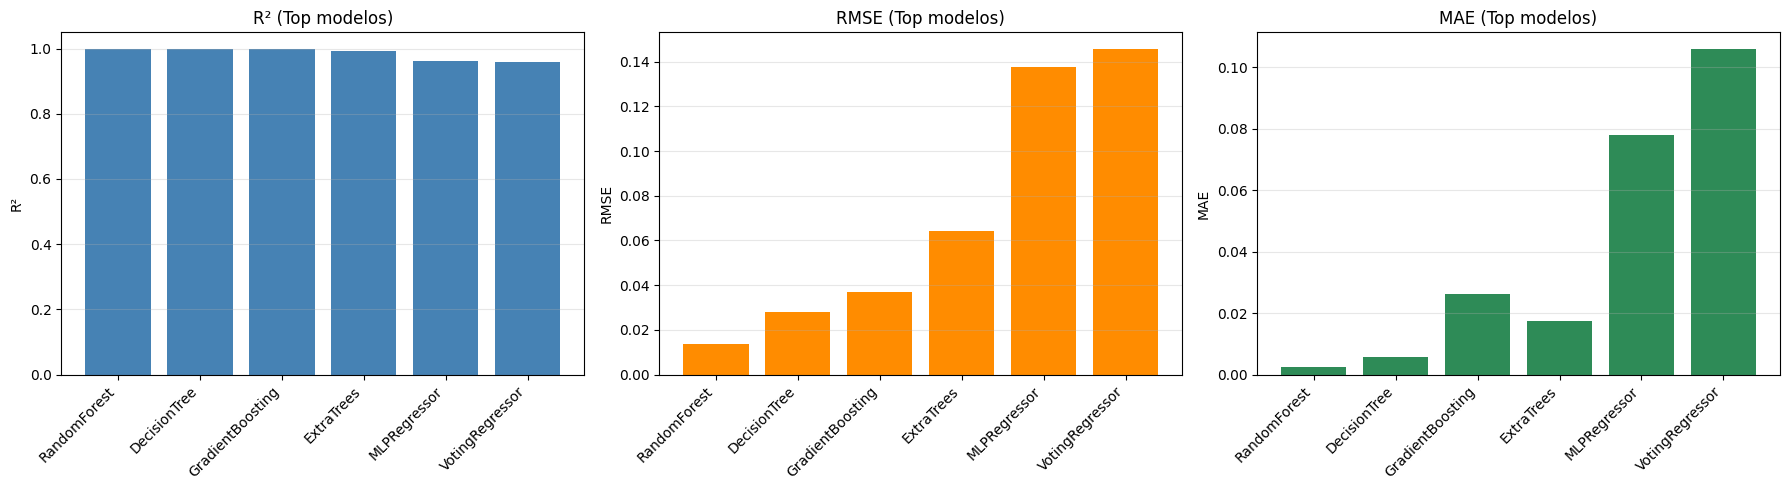

In [41]:
# Comparativa visual de los mejores modelos (según RMSE)
if 'results_reg' in globals():
    top_models = results_reg.sort_values('RMSE').head(6)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].bar(top_models['Model'], top_models['R2'], color='steelblue')
    axes[0].set_title('R² (Top modelos)')
    axes[0].set_ylabel('R²')
    axes[0].set_xticklabels(top_models['Model'], rotation=45, ha='right')
    axes[0].grid(True, alpha=0.3, axis='y')

    axes[1].bar(top_models['Model'], top_models['RMSE'], color='darkorange')
    axes[1].set_title('RMSE (Top modelos)')
    axes[1].set_ylabel('RMSE')
    axes[1].set_xticklabels(top_models['Model'], rotation=45, ha='right')
    axes[1].grid(True, alpha=0.3, axis='y')

    axes[2].bar(top_models['Model'], top_models['MAE'], color='seagreen')
    axes[2].set_title('MAE (Top modelos)')
    axes[2].set_ylabel('MAE')
    axes[2].set_xticklabels(top_models['Model'], rotation=45, ha='right')
    axes[2].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

### Residuales y métricas por segmento (bajo/medio/alto)

In [ ]:
# Ajuste de un modelo base para residuales (mejor RMSE)
if 'results_reg' in globals():
    best_name = results_reg.sort_values('RMSE').iloc[0]['Model']
    model_map = {name: model for name, model in models_reg}
    base_model = model_map.get(best_name, RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))

    pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', base_model)])
    pipe.fit(X_train, y_train)
    preds_log = pipe.predict(X_test)

    # Residuales (escala log)
    residuals = y_test - preds_log

    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, bins=40, kde=True)
    plt.title('Distribución de residuales (log)')
    plt.xlabel('Residual (y_true - y_pred)')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.scatter(preds_log, residuals, alpha=0.3)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs Predicted (log)')
    plt.xlabel('Predicción (log)')
    plt.ylabel('Residual')
    plt.tight_layout()
    plt.show()

    # Métricas por segmento (precio real)
    price_test = _df_model_final.loc[y_test.index, 'price_clean']
    pred_price = np.expm1(preds_log)

    segments = pd.qcut(price_test, q=3, labels=['low', 'mid', 'high'])
    seg_df = pd.DataFrame({
        'segment': segments,
        'price_true': price_test.values,
        'price_pred': pred_price
    })

    seg_metrics = seg_df.groupby('segment').apply(
        lambda d: pd.Series({
            'MAE': np.mean(np.abs(d['price_true'] - d['price_pred'])),
            'RMSE': np.sqrt(np.mean((d['price_true'] - d['price_pred'])**2)),
            'N': len(d)
        })
    )

    seg_metrics

## 10) Ajuste de hiperparametros (subset)

In [ ]:
param_grids = {
    'Ridge': {
        'model__alpha': [0.1, 1.0, 10.0]
    },
    'RandomForest': {
        'model__n_estimators': [200, 400],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5]
    },
    'SVR_RBF': {
        'model__C': [1, 10],
        'model__gamma': ['scale', 0.1]
    },
    'MLPRegressor': {
        'model__hidden_layer_sizes': [(64, 32), (128, 64)],
        'model__alpha': [0.0001, 0.001]
    }
}

best_models = {}

for name, model in models_reg:
    if name not in param_grids:
        continue
    pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])
    grid = GridSearchCV(pipe, param_grids[name], cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(name, "best RMSE:", -grid.best_score_)

best_models.keys()

Ridge best RMSE: 0.46042559966036994


## 11) Interpretabilidad (features y coeficientes)

In [ ]:
# Feature names para modelos con one-hot

def get_feature_names(preprocessor, num_features, cat_features):
    feat_names = list(num_features)
    if cat_features:
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_names = ohe.get_feature_names_out(cat_features).tolist()
        feat_names.extend(cat_names)
    return feat_names

# Feature importance con RandomForest
rf_pipe = Pipeline(steps=[('preprocess', preprocessor),
                         ('model', RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))])
rf_pipe.fit(X_train, y_train)

feat_names = get_feature_names(rf_pipe.named_steps['preprocess'], num_features, cat_features)
importances = pd.Series(rf_pipe.named_steps['model'].feature_importances_, index=feat_names)
importances.sort_values(ascending=False).head(15)

In [ ]:
# Coeficientes Ridge (lineal)
ridge_pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', Ridge(alpha=1.0))])
ridge_pipe.fit(X_train, y_train)

feat_names = get_feature_names(ridge_pipe.named_steps['preprocess'], num_features, cat_features)
coef = pd.Series(ridge_pipe.named_steps['model'].coef_, index=feat_names).sort_values(key=np.abs, ascending=False)
coef.head(15)

## 12) Clasificacion auxiliar por segmentos de precio

In [ ]:
# Segmentos de precio (bajo/medio/alto)
_df_class = _df_model_final.copy()
_df_class['price_segment'] = pd.qcut(_df_class['price_clean'], q=3, labels=['low', 'mid', 'high'])

Xc = _df_class.drop(columns=['log_price', 'price_clean', 'price_segment'], errors='ignore')
yc = _df_class['price_segment']

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=0.2, random_state=42, stratify=yc
)

# Preprocesamiento para clasificacion (reusamos)
num_features_c = Xc.select_dtypes(include=[np.number]).columns.tolist()
cat_features_c = Xc.select_dtypes(exclude=[np.number]).columns.tolist()

preprocessor_c = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features_c),
        ('cat', categorical_transformer, cat_features_c)
    ]
)

models_clf = [
    ('LogisticRegression', LogisticRegression(max_iter=1000)),
    ('KNN', KNeighborsClassifier(n_neighbors=7)),
    ('SVM_RBF', SVC(C=5, gamma='scale')),
    ('RandomForest', RandomForestClassifier(n_estimators=300, random_state=42))
]

if HAS_XGB:
    models_clf.append(('XGBoost', XGBClassifier(random_state=42)))

rows = []
for name, model in models_clf:
    pipe = Pipeline(steps=[('preprocess', preprocessor_c), ('model', model)])
    pipe.fit(Xc_train, yc_train)
    preds = pipe.predict(Xc_test)
    rows.append({
        'Model': name,
        'Accuracy': accuracy_score(yc_test, preds)
    })

pd.DataFrame(rows).sort_values(by='Accuracy', ascending=False)

In [ ]:
# LDA para visualizacion (solo numericas)
num_only = _df_class.select_dtypes(include=[np.number]).drop(columns=['log_price', 'price_clean'], errors='ignore')
num_only = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(num_only), columns=num_only.columns)

n_classes = _df_class['price_segment'].nunique()
max_comp = min(2, n_classes - 1, num_only.shape[1])

lda = LinearDiscriminantAnalysis(n_components=max_comp)
X_lda = lda.fit_transform(num_only, _df_class['price_segment'])

if max_comp >= 2:
    plt.figure(figsize=(7, 5))
    for label in ['low', 'mid', 'high']:
        mask = _df_class['price_segment'] == label
        plt.scatter(X_lda[mask, 0], X_lda[mask, 1], s=10, alpha=0.5, label=label)
    plt.title('LDA - Price Segments')
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    plt.legend()
    plt.show()
else:
    print('LDA no disponible: n_components insuficiente.')

## 13) Enfoques por actor (Usuario / Proveedor / Agencia)

Este bloque replica el enfoque de Josué: distintos objetivos según el actor.
- **Usuario:** predecir experiencia excelente (clasificación) usando `review_scores_rating`.
- **Proveedor (host):** predecir precio de mercado (regresión) con `log_price`.
- **Agencia:** predecir demanda (proxy) con `log_reviews_per_month`.

Se muestran ejemplos básicos de targets y modelos para cada caso.

In [ ]:
# Definición de targets por actor

def build_preprocessor_for(X):
    num = X.select_dtypes(include=[np.number]).columns.tolist()
    cat = X.select_dtypes(exclude=[np.number]).columns.tolist()
    return ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num),
            ('cat', categorical_transformer, cat)
        ]
    )

# ------------------
# ENFOQUE USUARIO (clasificación)
# ------------------
if 'review_scores_rating' in _df_model_final.columns:
    y_user = (_df_model_final['review_scores_rating'] > 4.8).astype(int)
    # Evitar leakage de disponibilidad / revenue si existen
    leak_user = [c for c in _df_model_final.columns if any(k in c for k in ['availability_', 'estimated_'])]
    X_user = _df_model_final.drop(columns=['log_price', 'price_clean', 'review_scores_rating'] + leak_user, errors='ignore')

    X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_user, y_user, test_size=0.2, random_state=42, stratify=y_user)
    pre_u = build_preprocessor_for(X_user)
    clf_user = Pipeline(steps=[('preprocess', pre_u), ('model', LogisticRegression(max_iter=1000))])
    clf_user.fit(X_train_u, y_train_u)
    preds_u = clf_user.predict(X_test_u)
    print('Usuario - Accuracy:', accuracy_score(y_test_u, preds_u))

# ------------------
# ENFOQUE PROVEEDOR (regresión precio)
# ------------------
if 'log_price' in _df_model_final.columns:
    y_prov = _df_model_final['log_price']
    leak_prov = [c for c in _df_model_final.columns if any(k in c for k in ['review', 'estimated_', 'occupancy'])]
    X_prov = _df_model_final.drop(columns=['log_price', 'price_clean'] + leak_prov, errors='ignore')

    X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_prov, y_prov, test_size=0.2, random_state=42)
    pre_p = build_preprocessor_for(X_prov)
    reg_prov = Pipeline(steps=[('preprocess', pre_p), ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))])
    reg_prov.fit(X_train_p, y_train_p)
    preds_p = reg_prov.predict(X_test_p)
    print('Proveedor - RMSE:', rmse(y_test_p, preds_p))

# ------------------
# ENFOQUE AGENCIA (regresión demanda)
# ------------------
if 'reviews_per_month' in _df_model_final.columns:
    _tmp = _df_model_final.copy()
    _tmp['log_reviews_per_month'] = np.log1p(_tmp['reviews_per_month'].fillna(0))

    y_agency = _tmp['log_reviews_per_month']
    leak_agency = [c for c in _tmp.columns if any(k in c for k in ['review', 'estimated_', 'occupancy', 'scraped'])]
    X_agency = _tmp.drop(columns=['log_reviews_per_month', 'log_price', 'price_clean'] + leak_agency, errors='ignore')

    X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_agency, y_agency, test_size=0.2, random_state=42)
    pre_a = build_preprocessor_for(X_agency)
    reg_agency = Pipeline(steps=[('preprocess', pre_a), ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))])
    reg_agency.fit(X_train_a, y_train_a)
    preds_a = reg_agency.predict(X_test_a)
    print('Agencia - RMSE:', rmse(y_test_a, preds_a))